![msg](msg.jpg)

# This is where I will try to get this to work by taking pieces from the discEvolution code

In [278]:
#Imports 
import astropy.units as u
import astropy.constants as const
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns 

from DiscEvolution.grid import Grid
from DiscEvolution.star import SimpleStar
from DiscEvolution.eos import LocallyIsothermalEOS  # or another EOS you prefer
from DiscEvolution.disc import AccretionDisc
from DiscEvolution.viscous_evolution import ViscousEvolutionFV  # Back to FV version

In [279]:
Mstar = 1.0 * u.solMass
gamma = 1.0
Rc = 1 * u.AU
M_disk_initial = (0.05 * u.solMass)
mu = 2.33

#alpha = ?
#Sigma_initial = ?

#let's take the disk to go out to 100 AU, starting from the stellar surface
#r_arr = np.linspace(const.R_sun.to('AU').value, 100, num=10000) * u.AU

t_final = 1  * u.Myr

In [280]:
# 1) Build grid (choose inner/outer radii and number of cells)
R_in = 0.1  #AU
R_out= 1000.0 #AU
Ncells = 400  # AU
grid = Grid(R_in, R_out, Ncells, spacing='natural')

In [281]:
# 2) Star + EOS
star = SimpleStar(age = 1)  #1 yr old , default 1 Msun

alpha = 1e-3         # Shakura–Sunyaev alpha

eos = LocallyIsothermalEOS(star, h0=1/30., q=-0.25, alpha_t=alpha)
eos.set_grid(grid)

In [282]:
#LBP disk with gamma = 1 

#Gas Surface Density 
def Sigma_gas_1(r) -> float:
    val = (M_disk_initial)/(2* np.pi * Rc * r) * np.exp((-1*r)/(Rc))
    if (val.cgs.unit != (u.g / (u.cm)**2)):
        print("Sigma_1 error")
        return 0
    return val.cgs

def Temperature(r) -> float:
    T_0 = 150 * u.K 
    val  = T_0 * (r / (1.0 * u.AU))**(-1/2)
    if val.cgs.unit != u.K:
        print('Temperature error')
        return 0
    return val.cgs

#Taken from A2
def Omega(r) -> float:
    val = np.sqrt((const.G*Mstar)/(r**3))
    if (val.cgs.unit != (1 / u.s)): 
        print("Omega error")
        return 0
    return val.cgs

#Taken from A2
def c_s(r) -> float:
    val = np.sqrt((const.k_B*Temperature(r))/(mu*const.m_p))
    if (val.cgs.unit != (u.cm / u.s)): 
        print("c_s error")
        return 0
    return val.cgs

In [283]:
# 3) Create the disc with initial surface density

# Your Sigma_1 is already analytically normalized to M_disk_initial
R_centers = grid.Rc  # AU
Sigma_initial = np.array([Sigma_gas_1(r * u.AU).value for r in R_centers])

# Create the accretion disc
disc = AccretionDisc(grid, star, eos, Sigma=Sigma_initial)
disc._planetesimal = False

# Override with your custom temperature profile
T_custom = np.array([Temperature(r * u.AU).value for r in disc.R])
cs_custom = np.array([c_s(r * u.AU).value for r in disc.R])

disc._eos._T = T_custom
disc._eos._cs = cs_custom
disc._eos._H = cs_custom / disc.Omega_k
disc._eos._nu = disc._eos._alpha_t * cs_custom * disc._eos._H

# FIX: Prevent T property from recalculating
disc._eos._T0 = 1.0  # Now T = 1.0 * cs**2 won't corrupt your custom _T



print(f"Disc created successfully!")
print(f"Total mass: {disc.Mtot() / const.M_sun.to(u.g).value:.3e} solMass")
print(f"Input disk mass: {M_disk_initial.to(u.M_sun):.3e}")
# Find index closest to 1 AU
idx_1au = np.argmin(np.abs(disc.R - 1.0))
print(f"Temperature at 1 AU (r={disc.R[idx_1au]:.2f} AU): {disc._eos._T[idx_1au]:.1f} K")
print(f"Sound speed at 1 AU: {c_s(1.0 * u.AU).value:.2e} cm/s")
print(f"Outer radius: {disc.Rout():.1f} AU")
print(f"Grid cells: {disc.Ncells}")

Disc created successfully!
Total mass: 4.540e-02 solMass
Input disk mass: 5.000e-02 solMass
Temperature at 1 AU (r=0.96 AU): 152.8 K
Sound speed at 1 AU: 7.29e+04 cm/s
Outer radius: 19.9 AU
Grid cells: 400


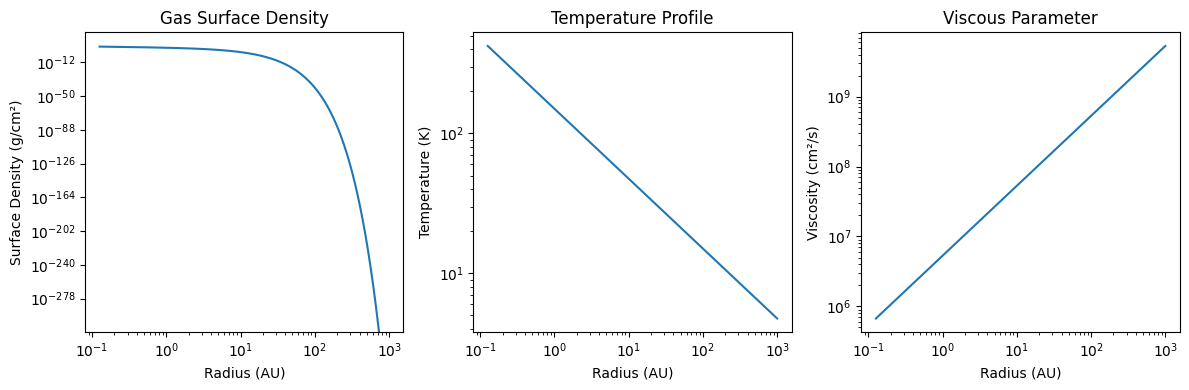

Disc properties verified!


In [284]:
# 4) Quick visualization to verify the disc setup

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.loglog(disc.R, disc.Sigma_G)
plt.xlabel('Radius (AU)')
plt.ylabel('Surface Density (g/cm²)')
plt.title('Gas Surface Density')

plt.subplot(1, 3, 2)
plt.loglog(disc.R, disc._eos._T)  # Use the actual custom T array you set
plt.xlabel('Radius (AU)')
plt.ylabel('Temperature (K)')
plt.title('Temperature Profile')

plt.subplot(1, 3, 3)
plt.loglog(disc.R, disc.nu)
plt.xlabel('Radius (AU)')
plt.ylabel('Viscosity (cm²/s)')
plt.title('Viscous Parameter')

plt.tight_layout()
plt.show()

print("Disc properties verified!")

In [285]:
# 5) Set up viscous evolution and run a short test

# Create the viscous evolution solver (using FV version like the example)
visc_evol = ViscousEvolutionFV(tol=0.5, boundary='power_law', in_bound='Mdot')

# Calculate the maximum stable timestep
dt_max = visc_evol.max_timestep(disc)
print(f"Maximum stable timestep: {dt_max:.2e} yr")

# Run a few viscous evolution steps
n_steps = 10
dt = dt_max * 0.5  # Use half the max for safety

print(f"Running {n_steps} viscous evolution steps with dt = {dt:.2e} yr")

# Store initial mass for comparison
mass_initial = disc.Mtot()

for i in range(n_steps):
    # Update the disc using viscous evolution
    visc_evol(dt, disc)
    
    if i % 2 == 0:  # Print every other step
        mass_current = disc.Mtot()
        print(f"Step {i+1}: Mass = {mass_current/mass_initial:.6f} (fraction of initial)")

print("Viscous evolution test completed!")
print(f"Final mass: {disc.Mtot()/mass_initial:.6f} of initial mass")
print(f"Final outer radius: {disc.Rout():.1f} AU")

Maximum stable timestep: 3.84e-10 yr
Running 10 viscous evolution steps with dt = 1.92e-10 yr
Step 1: Mass = nan (fraction of initial)
Step 3: Mass = nan (fraction of initial)
Step 5: Mass = nan (fraction of initial)
Step 7: Mass = nan (fraction of initial)
Step 9: Mass = nan (fraction of initial)
Viscous evolution test completed!
Final mass: nan of initial mass
Final outer radius: 19.9 AU


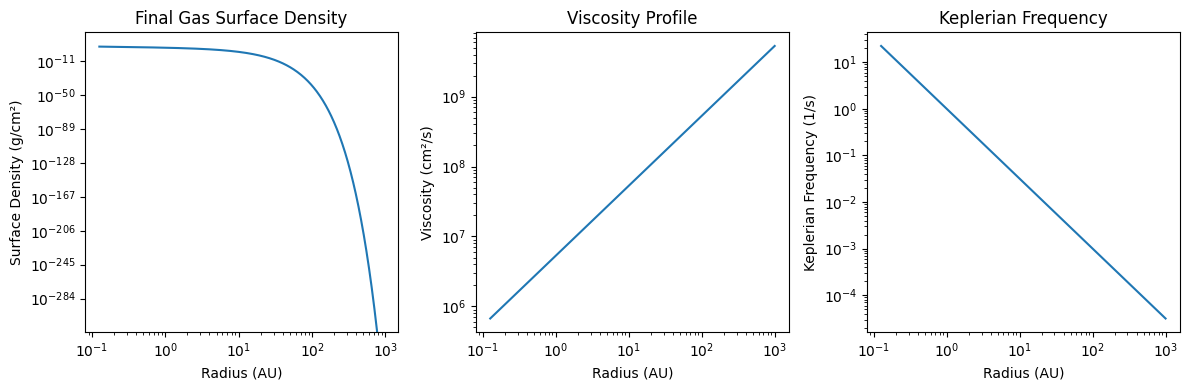

DiscEvolution setup and basic viscous evolution working! 🎉
Ready to add more physics modules (dust, chemistry, photoevaporation, etc.)


In [286]:
# 6) Final visualization showing disc evolution

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.loglog(disc.R, disc.Sigma_G)
plt.xlabel('Radius (AU)')
plt.ylabel('Surface Density (g/cm²)')
plt.title('Final Gas Surface Density')

plt.subplot(1, 3, 2)
plt.loglog(disc.R, disc.nu)
plt.xlabel('Radius (AU)')
plt.ylabel('Viscosity (cm²/s)')
plt.title('Viscosity Profile')

plt.subplot(1, 3, 3)
plt.loglog(disc.R, disc.Omega_k)
plt.xlabel('Radius (AU)')
plt.ylabel('Keplerian Frequency (1/s)')
plt.title('Keplerian Frequency')

plt.tight_layout()
plt.show()

print("DiscEvolution setup and basic viscous evolution working! 🎉")
print(f"Ready to add more physics modules (dust, chemistry, photoevaporation, etc.)")